This is a demo notebook to query SAM2 model to extract key objects in an image.

In [ ]:
import torch
from transformers import (
    Qwen2VLForConditionalGeneration,
    Qwen2_5_VLForConditionalGeneration, 
    AutoTokenizer, AutoProcessor
)
from PIL import Image, ImageDraw
from IPython import display
import json
import re

checkpoint_path = "Qwen/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(checkpoint_path, device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint_path)

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/path/to/sam2/sam2.1_hiera_large.pt" # please follow https://github.com/facebookresearch/sam2
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
import os
import numpy as np
import ast
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def resize_image(image):
    original_width, original_height = image.size
    
    scale = 1120 / max(original_width, original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    resized_image = image.resize((new_width, new_height))
    
    return resized_image

def qwenvl_query_keypoint(image, label):    
    prompt = f"""Detect the key point of the "{label}", return it in the form of points"""
    print(prompt)
    conversation = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]

    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(model.device)
            
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=64,
        )

    generated_ids = [output_ids[i][len(inputs.input_ids[i]):] for i in range(len(output_ids))]
    response = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
    print(response)
    match = re.search(r'\[\s*\d+\s*,\s*\d+\s*\]', response.replace('\n', '').strip())
    if match:
        try:
            keypoint = ast.literal_eval(f"{match.group()}")
            return keypoint
        except (SyntaxError, ValueError):
            pass
    return None


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2)) 

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        # if len(scores) > 1:
        #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.savefig('temp.png', bbox_inches='tight', pad_inches=0)
        # plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.show()

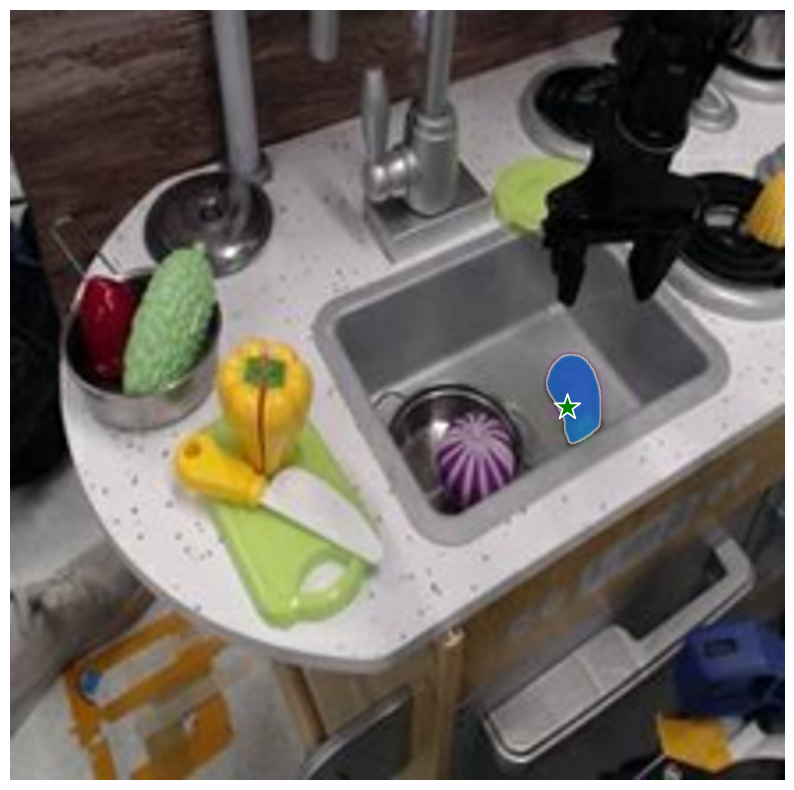

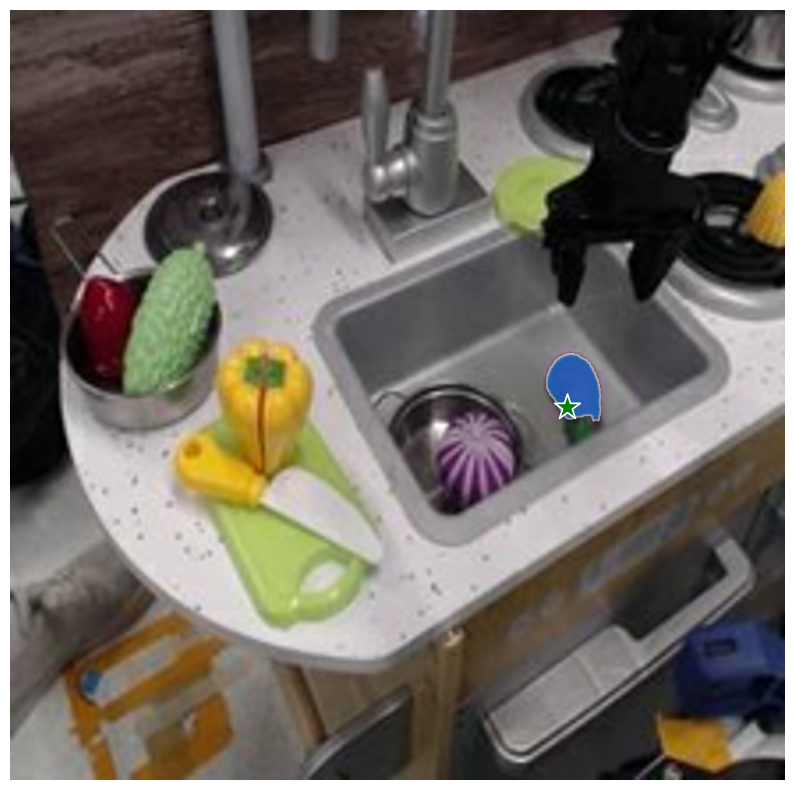

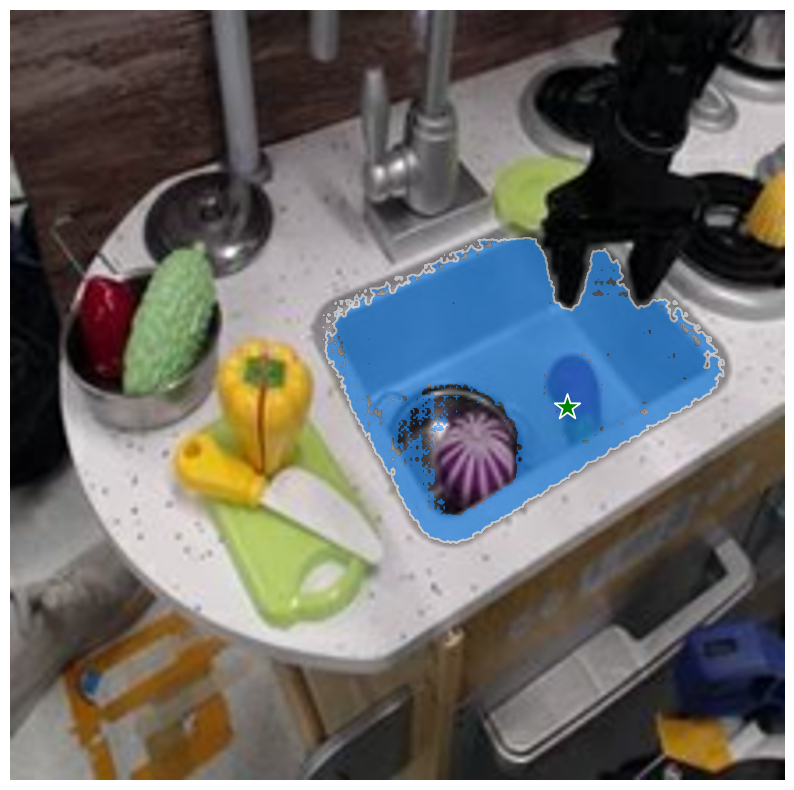

775 498 853 627


In [ ]:
image = resize_image(Image.open("test.png"))
label = "eggplant"

result = qwenvl_query_keypoint(image, label)
if result is not None:
    draw = ImageDraw.Draw(image)
    radius = 3
    pt = result
    draw.ellipse((pt[0] - radius, pt[1] - radius, pt[0] + radius, pt[1] + radius), fill="red")
else:
    raise Exception("Not found!")

predictor.set_image(image)
input_point = np.array([result])
input_label = np.array([1]) # foreground point, background point
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

nonzero_indices = np.argwhere(masks[0] != 0)
min_x = nonzero_indices[:, 1].min().item()
max_x = nonzero_indices[:, 1].max().item()
min_y = nonzero_indices[:, 0].min().item()
max_y = nonzero_indices[:, 0].max().item()
print(min_x, min_y, max_x, max_y)

draw = ImageDraw.Draw(image)

In [36]:
nonzero_indices = np.argwhere(masks[0] != 0)
min_x = nonzero_indices[:, 1].min().item()
max_x = nonzero_indices[:, 1].max().item()
min_y = nonzero_indices[:, 0].min().item()
max_y = nonzero_indices[:, 0].max().item()
print()
image.crop([min_x, min_y, max_x, max_y]).save("tmp.jpg")

In [27]:
image.save("test.jpg")